In [1]:
import pandas
import numpy
from scipy.stats import binom

In [2]:
data = pandas.read_csv('compas-scores-two-years.csv.gz')

In [3]:
data

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


# Point Estimate

In [4]:
data.groupby('age_cat')['two_year_recid'].mean()

age_cat
25 - 45            0.459723
Greater than 45    0.315990
Less than 25       0.565075
Name: two_year_recid, dtype: float64

## Bootstrap

In [15]:
bss = pandas.DataFrame([
    data.sample(data.shape[0], replace=True).
    groupby('age_cat')['two_year_recid'].mean()
    for _ in range(1000)])

<AxesSubplot:ylabel='Frequency'>

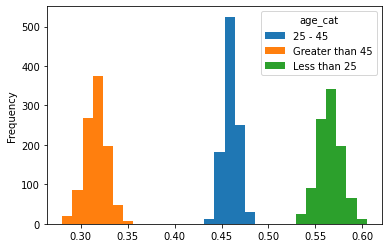

In [16]:
bss.plot.hist(bins=30)

In [17]:
(bss['25 - 45'] > bss['Greater than 45']).mean()

1.0

In [18]:
import seaborn as sns

In [19]:
sns.set_theme()

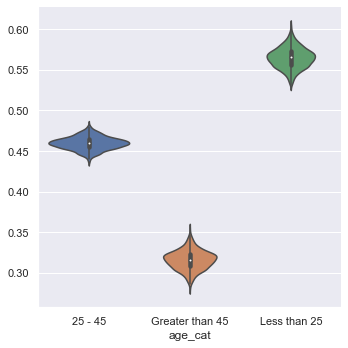

In [25]:
sns.catplot(data=bss, kind='violin')

## Binomial

In [26]:
params = pandas.DataFrame({
    'N': data.groupby('age_cat').size(),
    'k': data.groupby('age_cat')['two_year_recid'].sum(),
})

In [27]:
params

,N,k
age_cat,,
25 - 45,4109,1889
Greater than 45,1576,498
Less than 25,1529,864


In [29]:
params['k'] / params['N'] # point estimates from above

age_cat
25 - 45            0.459723
Greater than 45    0.315990
Less than 25       0.565075
dtype: float64

In [30]:
thetas = numpy.linspace(0.25, 0.65, 500)

In [31]:
binom(1576, 0.3).pmf(498)

0.00835810577937903

In [34]:
import matplotlib.pyplot as plt

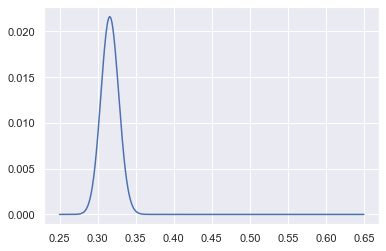

In [35]:
plt.plot(thetas, binom(1576, thetas).pmf(498))

<AxesSubplot:>

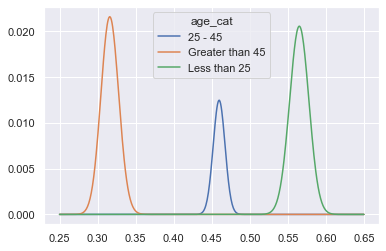

In [42]:
params.apply(lambda x: binom(x['N'], thetas)
             .pmf(x['k']), axis=1, result_type='expand')\
.T.set_index(thetas).plot.line()

## Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
X = pandas.get_dummies(data['age_cat'], drop_first=True)
y = data['two_year_recid']

In [45]:
X.columns

Index(['Greater than 45', 'Less than 25'], dtype='object')

In [52]:
m = LogisticRegression(penalty='none').fit(X, y)

In [53]:
m.coef_

array([[-0.61080397,  0.42324471]])

In [54]:
m.intercept_

array([-0.16145935])

In [49]:
p = data.groupby('age_cat')['two_year_recid'].mean()

In [55]:
p

age_cat
25 - 45            0.459723
Greater than 45    0.315990
Less than 25       0.565075
Name: two_year_recid, dtype: float64

In [56]:
numpy.log(p['25 - 45'] / (1 - p['25 - 45']))

-0.16145960736481563

In [57]:
numpy.log(p['Greater than 45'] / (1 - p['Greater than 45']) / p['25 - 45'] * (1 - p['25 - 45']))

-0.6108030670794741

In [58]:
df = X.join(y)

In [59]:
feat = X.columns

In [62]:
coef, intercept = [], []
for _ in range(500):
    sample = df.sample(df.shape[0], replace=True)
    m = LogisticRegression(penalty='none').fit(sample[feat], sample['two_year_recid'])
    coef.append(m.coef_[0])
    intercept.append(m.intercept_[0])

(array([  6.,  12.,  43.,  90., 112., 111.,  76.,  33.,  14.,   3.]),
 array([-0.25312259, -0.23437725, -0.2156319 , -0.19688656, -0.17814121,
        -0.15939587, -0.14065052, -0.12190518, -0.10315983, -0.08441449,
        -0.06566914]),
 <BarContainer object of 10 artists>)

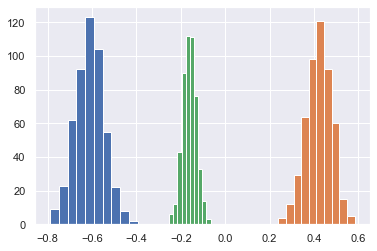

In [63]:
plt.hist(numpy.array(coef)[:,0])
plt.hist(numpy.array(coef)[:,1])
plt.hist(intercept)

(array([ 0.64015893,  1.28031785,  4.58780564,  9.60238389, 11.94963329,
        11.84294013,  8.10867973,  3.52087409,  1.49370416,  0.32007946]),
 array([-0.25312259, -0.23437725, -0.2156319 , -0.19688656, -0.17814121,
        -0.15939587, -0.14065052, -0.12190518, -0.10315983, -0.08441449,
        -0.06566914]),
 <BarContainer object of 10 artists>)

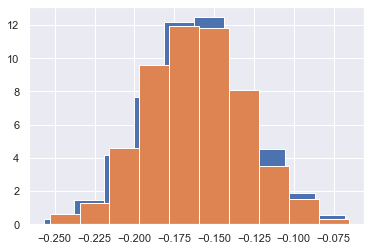

In [69]:
plt.hist(numpy.log(bss['25 - 45'] / (1 - bss['25 - 45'])), density=True)
plt.hist(intercept, density=True)